https://colab.research.google.com/drive/1DhkqsnOklP8WsJ9X-Mk1VmfzWw4Sp2uC?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score

# Обработка и визуализация данных

Загрузим тренировочную выборку.

In [ ]:
df_train = pd.read_csv("train.csv")
df_train.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

Удалим столбец Id, т.к. он ни на что не влияет.

In [ ]:
df_train = df_train.drop('Id',1)

Посмотрим общую информацию о датафрейме.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Посмотрим описательную статистику по интересующему нас столбцу

In [ ]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Мы видим, что минимальная цена больше нуля.

## Визуализация данных

Отобразим ключевой признак на гистограмме.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


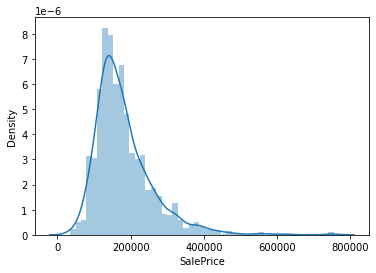

In [ ]:
sns.distplot(df_train['SalePrice'])

Целевой переменной является положительная асимметрия, преобразуем её с помощью функции numpy

Отобразим матрицу корреляции в стиле тепловой карты

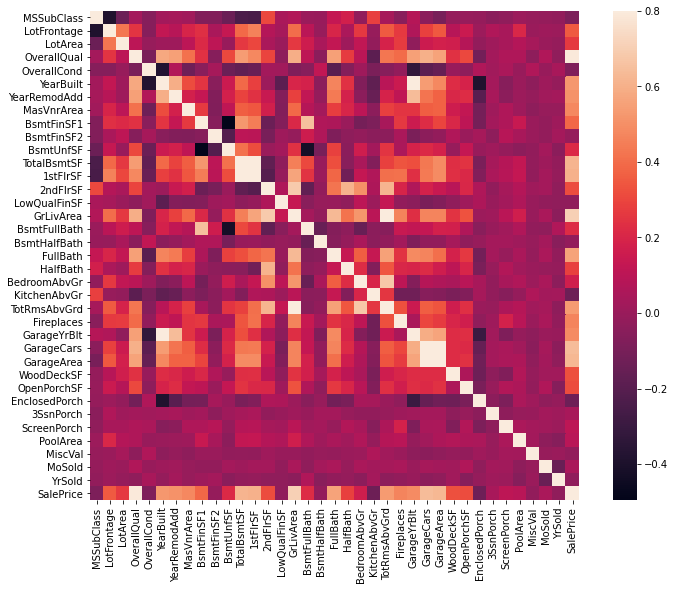

In [ ]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Привлекают внимания два белых квадрата. Первый относится к переменным TotalBsmtSf и 1stFirSF. Второй к переменным GarageX. Оба случая показывают, насколько значительна корреляция между этими переменными. Эта корреляция настолько сильна, что может указывать на ситуацию мультиколлинеарности. Если мы подумаем об этих переменных, мы можем сделать вывод, что они дают почти одинаковую информацию, поэтому мультиколлинеарность действительно имеет место.

Изобразим матрицу корреляции SalePrice в стиле уменьшенной тепловой карты.

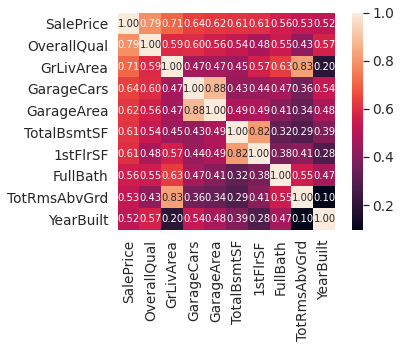

In [ ]:
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

TotalQual, GrLivArea и TotalBsmtSF сильно коррелируют с SalePrice.
«GarageCars» и «GarageArea» также являются одними из наиболее сильно коррелированных переменных. Однако, как мы обсуждали в последнем подпункте,
Количество машин, которые помещаются в гараж, зависит от площади гаража. GarageCars и GarageArea практически одинаковые.Следовательно, можно оставить только одну из этих переменных (мы можем оставить GarageCars, поскольку ее корреляция с SalePrice выше).
TotalBsmtSF и 1stFloor тоже кажутся похожими. Мы можем оставить «TotalBsmtSF».

Построим диаграммы разброса между SalePrice и коррелированными переменными

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


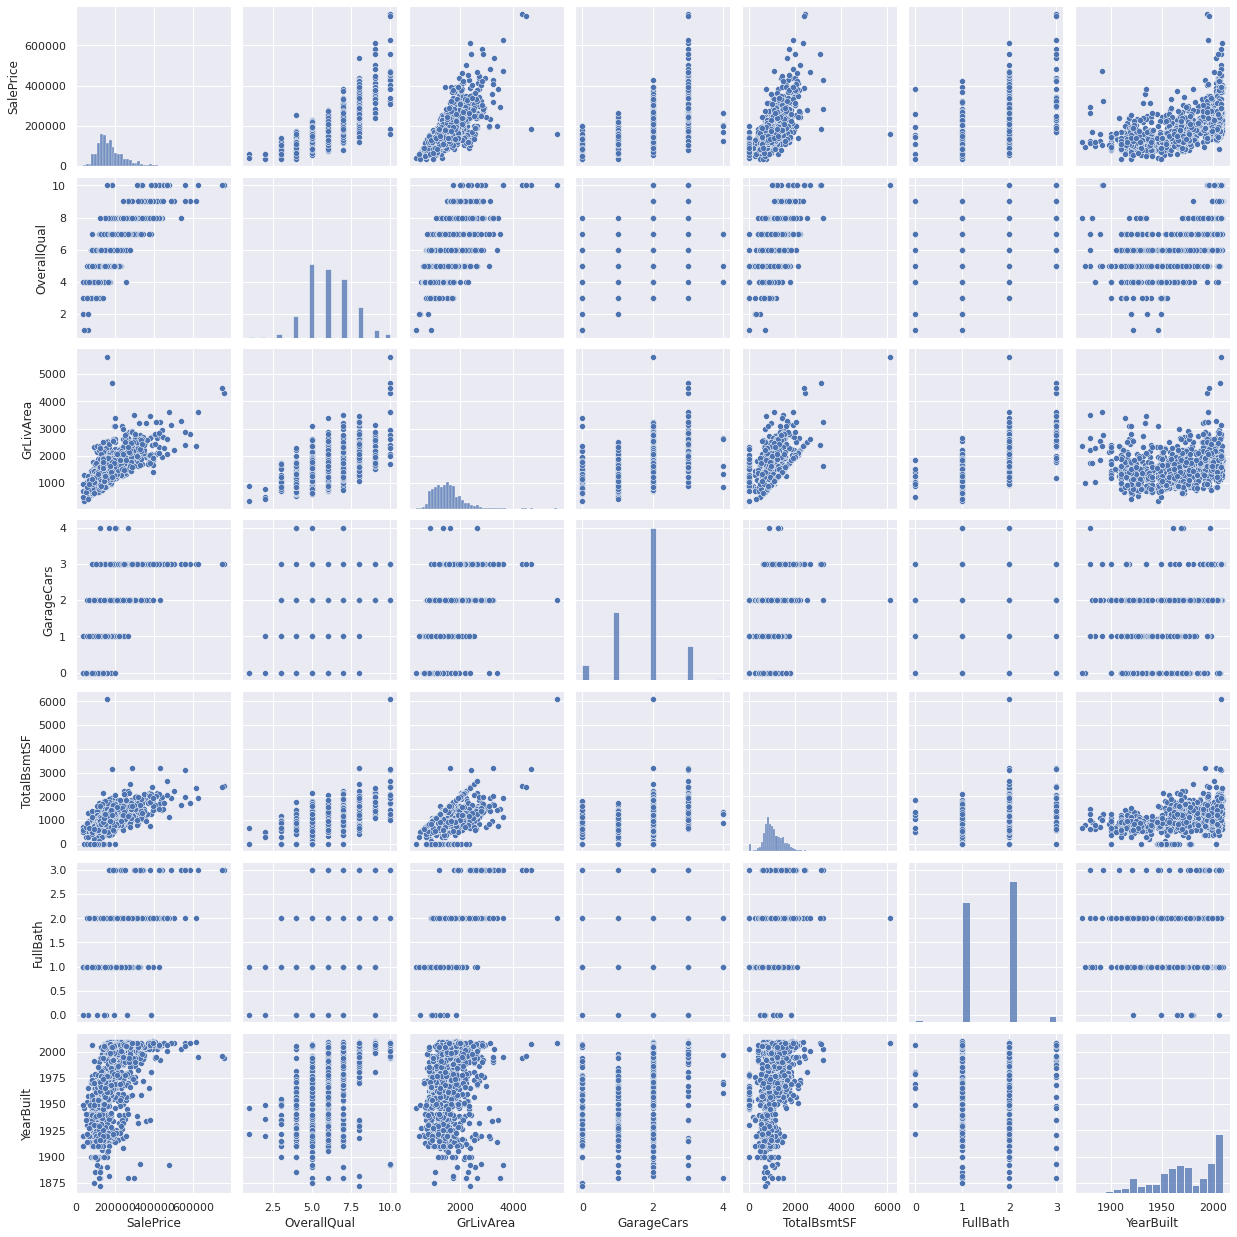

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

Одна из диаграмм, которая может показаться нам интересной, - это диаграмма между TotalBsmtSF и GrLiveArea. На этом рисунке мы можем видеть, как точки рисуют линию, которая почти действует как граница. Большинство точек остаются ниже этой линии. Площадь подвала может быть равна жилой площади над землей, но не предполагается, что площадь подвала больше жилой площади над землей.


## Обработка пропусков

Отобразим количество недостающих данных, в таблице.

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
RoofMatl          0  0.000000

Удалим те признаки в которых процент отсутствующих значений больше 15. Так же удалим переменные GarageX, т.к. наиболее важная информация содержится в GarageCars. Та же логика применима к переменным BsmtX. Т.к. в признаке Electrical отсутствует только 1 значение удалим это наблюдение.

In [ ]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

In [ ]:
df_train =df_train.reset_index(drop=True)

Отделим от данных целевой признак

In [ ]:
y_train = df_train['SalePrice']
X_train = df_train.drop('SalePrice', 1)

Загрузим данные по которым нам нужно предсказать цену дома.

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head()

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Обработаем эти данные от пропусков, таким же образом.

In [ ]:
total_test = df_test.isnull().sum().sort_values(ascending=False)
percent_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(20)

Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageQual       78  0.053461
GarageYrBlt      78  0.053461
GarageFinish     78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtQual         44  0.030158
BsmtExposure     44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371

In [ ]:
df_test = df_test.drop((missing_data_test[missing_data_test['Total'] > 4]).index,1)
df_test.isnull().sum().max()

4

Заполним строчки с пропусками самыми популярными значениями по каждой категории.

In [ ]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
df_test['BsmtHalfBath'] = df_test['BsmtHalfBath'].fillna(0.0)
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].fillna(0.0)
df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
df_test['GarageCars'] = df_test['GarageCars'].fillna(2.0)
df_test['GarageArea'] = df_test['GarageArea'].fillna(0.0)
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('VinylSd')
df_test['BsmtFinSF1'] = df_test['BsmtFinSF1'].fillna(0.0)
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('VinylSd')
df_test['SaleType'] = df_test['SaleType'].fillna('WD')
df_test['TotalBsmtSF'] = df_test['TotalBsmtSF'].fillna(0.0)
df_test['BsmtUnfSF'] = df_test['BsmtUnfSF'].fillna(0.0)
df_test['BsmtFinSF2'] = df_test['BsmtFinSF2'].fillna(0.0)

In [ ]:
df_test =df_test.reset_index(drop=True)

In [ ]:
Id_test = df_test['Id']

In [ ]:
df_test = df_test.drop('Id',1)

Объеденим тренировочные и тестовые данные для кодирования котегориальных признаков.

In [ ]:
X = pd.concat([X_train, df_test])

In [ ]:
X = X.reset_index(drop = True)
X.head()

MSSubClass MSZoning  LotArea Street  ... MoSold YrSold SaleType SaleCondition
0          60       RL     8450   Pave  ...      2   2008       WD        Normal
1          20       RL     9600   Pave  ...      5   2007       WD        Normal
2          60       RL    11250   Pave  ...      9   2008       WD        Normal
3          70       RL     9550   Pave  ...      2   2006       WD       Abnorml
4          60       RL    14260   Pave  ...     12   2008       WD        Normal

[5 rows x 61 columns]

## Кодирование категориальных признаков

Разделим общий набор на категориальные и числовые признаки

In [ ]:
category_cols = X.select_dtypes(['object']).columns
numerical_cols = X.select_dtypes(['float64', 'int64']).columns

In [ ]:
X_cat = X[category_cols]
X_num = X[numerical_cols]

Перекодируем категориальные признаки.

In [ ]:
encoder = DV(sparse = False)
cat_encoded = encoder.fit_transform(X_cat.T.to_dict().values())
print(cat_encoded)

[[1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]]


Объединим перекодированные категориальные признаки и числовые.

In [ ]:
X_encoded = pd.concat([pd.DataFrame(cat_encoded),X_num],axis = 1)

In [ ]:
X_encoded

0    1    2    3    4  ...  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold
0     1.0  0.0  0.0  0.0  0.0  ...            0         0        0       2    2008
1     1.0  0.0  0.0  0.0  0.0  ...            0         0        0       5    2007
2     1.0  0.0  0.0  0.0  0.0  ...            0         0        0       9    2008
3     1.0  0.0  0.0  0.0  0.0  ...            0         0        0       2    2006
4     1.0  0.0  0.0  0.0  0.0  ...            0         0        0      12    2008
...   ...  ...  ...  ...  ...  ...          ...       ...      ...     ...     ...
2913  0.0  0.0  0.0  1.0  0.0  ...            0         0        0       6    2006
2914  0.0  0.0  0.0  0.0  1.0  ...            0         0        0       4    2006
2915  1.0  0.0  0.0  0.0  0.0  ...            0         0        0       9    2006
2916  1.0  0.0  0.0  0.0  0.0  ...            0         0      700       7    2006
2917  1.0  0.0  0.0  0.0  0.0  ...            0         0        0      11    2006

[2918 rows x 220 columns]

Отделим тренировочную и тестовую выборки

In [ ]:
X_encoded_train = X_encoded.iloc[0:1459]
X_encoded_test = X_encoded.iloc[1459:]

# Выбор модели регрессии

Разделим тренировочную выборку на 2 части: тренировочную и тестовую для подбора наилучших модели и гиперпараметров.

In [ ]:
(X_train_train, X_train_test, y_train_train, y_train_test) = train_test_split(X_encoded_train, y_train,test_size = 0.2, random_state = 0)

## ElasticNet

Elastic Net регрессия
Осуществляется с помощью sklearn.linear_model.ElasticNet

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
en = ElasticNet(random_state=123)
en.fit(X_train_train, y_train_train)
y_pred_train_en = en.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_en))

0.857438926944929


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776439152927.7115, tolerance: 742969215.2119777
  positive)


Подберём параметры по сетке с помощью sklearn.model_selection.GridSearchCV.

In [ ]:
en_parameters_grid = {'alpha' : np.arange(0.01, 1.0, 0.05),
                         'l1_ratio' : np.arange(0.1, 1.0, 0.1),
                         'max_iter' : [10, 50 ,100, 200,400],
                         'fit_intercept' : [True, False],
                         'normalize' : [True, False],
                         'selection' : ['cyclic', 'random'],
                         }

In [ ]:
en_grid = GridSearchCV(en, en_parameters_grid, cv = 5, n_jobs=-1, verbose=True)
en_grid.fit(X_train_train, y_train_train)
en_grid.best_params_

In [ ]:
en_with_params = ElasticNet(alpha = 0.11, fit_intercept = False,normalize = True,l1_ratio=0.9,max_iter=100,random_state= 123,selection='random')
en_with_params.fit(X_train_train, y_train_train)
y_pred_train_en = en_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_en))

0.8936968452429231


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515539126877.91473, tolerance: 4594849705.7277
  positive)


С помощью кросс валидации проверим модель на разных отрезках выборки.

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
en_cv = cross_val_score(en_with_params, X_train_train, y_train_train, cv=cv).mean()
en_cv

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278747411865.49817, tolerance: 3189937308.2855
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383914059451.0457, tolerance: 3267352102.228
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308032496451.4126, tolerance: 3178689661.196
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372382719323.54065,

0.8275215986658239

## Регрессия случайного леса

Осуществляется с помощью sklearn.ensemble.RandomForestRegressor.

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [ ]:
rfr = RandomForestRegressor(random_state=123).fit(X_train_train, y_train_train)
y_pred_train_rfr = rfr.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_rfr))

0.889591673056833


Подберём и здесь гиперпараметры.

In [ ]:
rfr_parameters_grid = {
                      'criterion' : ['mse', 'mae'],
                      'n_estimators' : [100,200,500],
                      'max_depth' : [2, 5, 10]

}

In [ ]:
rfr_grid = GridSearchCV(rfr, rfr_parameters_grid,
                        cv=5, n_jobs=-1, verbose=True)
rfr_grid.fit(X_train_train, y_train_train)
rfr_grid.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 21.9min finished


{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 500}

In [ ]:
rfr_with_params = RandomForestRegressor(max_depth=40,n_estimators=500,random_state=123).fit(X_train_train, y_train_train)
y_pred_train_rfr = rfr_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_rfr))

0.8870612831148811


Проверим модель на кросс валидации, как и прошлую.

In [ ]:
rfr_cv = cross_val_score(rfr, X_train_train, y_train_train, cv=cv).mean()
rfr_cv

0.8711567676530784

## Градиентный бустинг

Осуществляется с помощью sklearn.ensemble.GradientBoostingRegressor.

Ссылка на документацию: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [ ]:
gbr = GradientBoostingRegressor(random_state=123)
gbr.fit(X_train_train, y_train_train)
y_pred_train_gbr = gbr.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_gbr))

0.8912524186367744


Попробуем улучшить модель, подбором гиперпараметров

In [ ]:
gbr_parameters_grid = {
    'loss' : ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate' : np.arange(0.1, 0.8, 0.1),
    'n_estimators' : [50, 100 , 500]
}

In [ ]:
gbr_grid = GridSearchCV(gbr, gbr_parameters_grid,
                        cv=5, n_jobs=-1, verbose=True)
gbr_grid.fit(X_train_train, y_train_train)
gbr_grid.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  7.7min finished


({'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 500}, 0.8762561882861087)

In [ ]:
gbr_with_params = GradientBoostingRegressor(n_estimators=500,random_state=123)
gbr_with_params.fit(X_train_train, y_train_train)
y_pred_train_gbr = gbr_with_params.predict(X_train_test)
print(r2_score(y_train_test, y_pred_train_gbr))

0.909398736098662


Проверим среднюю оценку по выборке.

In [ ]:
gbr_cv = cross_val_score(gbr_with_params,X_train_train, y_train_train, cv=cv).mean()
gbr_cv

0.9071303468984052

## Сравнение моделей

ОбЪеденим в датафрейм все предсказанные ранее значения и истинное.

In [ ]:
predicts = pd.DataFrame({'ElasticNet':y_pred_train_en, 'RandomForest': y_pred_train_rfr,
                         'GradientBoosting':y_pred_train_gbr, 'TrueData':y_train_test})
predicts.head()

ElasticNet  RandomForest  GradientBoosting  TrueData
1419  159606.927820    164492.440     166340.283388    179900
494    84695.559272    102738.782      84964.975933     91300
1411  107292.222221     96452.900      98834.605009     90000
569   134525.603234    141158.696     133197.508355    135960
486   156450.683074    142456.798     146174.359299    156000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

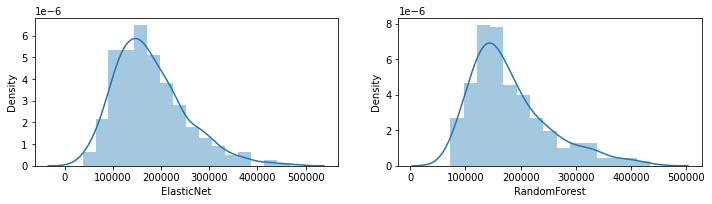

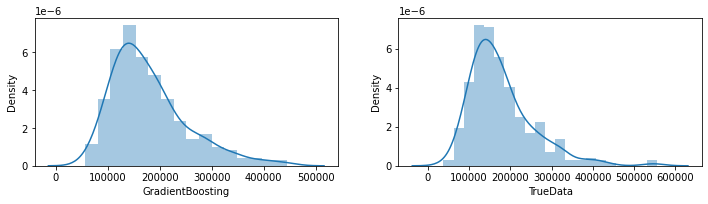

In [ ]:
plt.subplots(figsize = (25,6))
plt.subplot(2, 4, 1)
sns.distplot(predicts['ElasticNet'])
plt.subplot(2, 4, 2)
sns.distplot(predicts['RandomForest'])
plt.subplots(figsize = (25,6))
plt.subplot(2, 4, 3)
sns.distplot(predicts['GradientBoosting'])
plt.subplot(2, 4, 4)
sns.distplot(predicts['TrueData'])

Так же объединим и значение метрики.

In [ ]:
r2_scores = pd.DataFrame({'ElasticNet': en_cv,
                          'RandomForest': rfr_cv,
                          'GradientBoosting': gbr_cv},index = [0])

In [ ]:
r2_scores

ElasticNet  RandomForest  GradientBoosting
0    0.827522      0.871157          0.900798

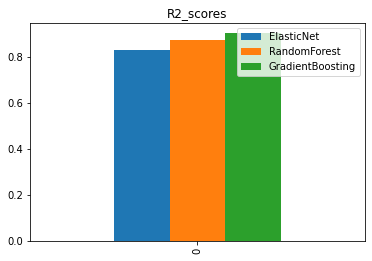

In [ ]:
r2_scores.plot(kind='bar', title='R2_scores')

# Формируем файл с ответом для загрузки на keggle

Обучаем ЛУчшую модель

In [ ]:
final = GradientBoostingRegressor(n_estimators=500, random_state=123)
final.fit(X_encoded_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Делаем предсказания

In [ ]:
y_pred_final = final.predict(X_encoded_test)

In [ ]:
y_pred_final = pd.DataFrame(y_pred_final,columns=['SalePrice'],index = Id_test)

In [ ]:
y_pred_final

SalePrice
Id                 
1461  122827.771423
1462  163840.547296
1463  181558.298680
1464  187362.008882
1465  179130.212852
...             ...
2915   82334.265248
2916   80071.579714
2917  148016.356000
2918  116504.639751
2919  231293.150178

[1459 rows x 1 columns]

Записываем файл csv

In [ ]:
y_pred_final.to_csv('predict.csv')